## **1. Data Preprocessing :**

### **1.1 Importing Libraries and Dataset**

In [ ]:
import re
import nltk
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.utils import resample
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score, recall_score, precision_score, f1_score

from keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Conv1D, GlobalMaxPool1D

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
new_data = pd.read_csv("/content/sentiment.csv", encoding='latin1')

<ipython-input-3-e291e0e4d148>:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  new_data = pd.read_csv("/content/sentiment.csv", encoding='latin1')


### **1.2 Handling Duplicates and Null Values**

In [ ]:
count_before = new_data.shape[0]
print("Count before removing duplicates:", count_before)

duplicates = new_data[new_data.duplicated()]
if not duplicates.empty:
    new_data.drop_duplicates(inplace=True)
    count_after = new_data.shape[0]
    print("Count after removing duplicates:", count_after)
else:
    print("No duplicates found.")

Count before removing duplicates: 171380
Count after removing duplicates: 147523


In [ ]:
null_values = new_data.isnull().sum()

print("Null values in new_data:")
print(null_values)


Null values in new_data:
ProductName     0
ProductPrice    1
Rate            1
Review          1
Summary         1
Sentiment       1
dtype: int64


In [ ]:
new_data.dropna(inplace=True)
null_values_after_drop = new_data.isnull().sum()

print("Null values after dropping rows:")
print(null_values_after_drop)


Null values after dropping rows:
ProductName     0
ProductPrice    0
Rate            0
Review          0
Summary         0
Sentiment       0
dtype: int64


### **1.3 Text Cleaning and Normalization**

In [ ]:
new_data = new_data[['Summary', 'Sentiment']].copy()

In [ ]:
new_data['Summary'] = new_data['Summary'].str.lower()

In [ ]:
text_with_single_quote = new_data['Summary']
pattern = r'\b\w*\'\w*\b'
words_with_single_quote = text_with_single_quote.str.findall(pattern)
words_with_single_quote = [word for sublist in words_with_single_quote for word in sublist]
print("Words containing ':")
print(set(words_with_single_quote))

Words containing ':
{"purchaseit's", "don't", "smartwatchit's", "they'll", "i'll", "timedon't", "monyit's", "aren't", "you'll", "sleeve's", "that's", "son's", "i'm", "isn't", "won't", "didn't", "moneydon't", "people's", "i've", "we'll", "tyre's", "jean's", "there's", "it'll", "today's", "athlete's", "let's", "ondon't", "it's", "worksit's", "haven't", "money's", "productdon't", "can't", "hour's", "shouldn't", "watchdon't", "did't", "month's", "cann't", "providedit's", "wouldn't", "battery's", "india's", "fastdon't", "doesn't", "one's", "wasn't", "qualitydon't", "5'10", "cycle's", "couldn't", "day's", "quicklyi'm", "person's"}


In [ ]:
CONTRACTION_MAPPING = {"ain't": "is not", "aren't": "are not","can't": "cannot", "cant": "cannot",
                   "can't've": "cannot have", "'cause": "because", "could've": "could have",
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not",
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not",
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will",
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did",
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                   "I'll've": "I will have","I'm": "I am", "I've": "I have",
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
                   "i'll've": "i will have","i'm": "i am", "i've": "i have",
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
                   "it'll": "it will", "it'll've": "it will have","it's": "it is",
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not",
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                   "she's": "she is", "should've": "should have", "shouldn't": "should not",
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is",
                   "there'd": "there would", "there'd've": "there would have","there's": "there is",
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
                   "they'll've": "they will have", "they're": "they are", "they've": "they have",
                   "to've": "to have", "wasn't": "was not", "we'd": "we would",
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                   "we're": "we are", "we've": "we have", "weren't": "were not",
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                   "what's": "what is", "what've": "what have", "when's": "when is",
                   "when've": "when have", "where'd": "where did", "where's": "where is",
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have",
                   "who's": "who is", "who've": "who have", "why's": "why is",
                   "why've": "why have", "will've": "will have", "won't": "will not",
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def decontracted(phrase):
    phrase = phrase.lower()
    for word in phrase.split():
        if word in CONTRACTION_MAPPING:
            phrase = phrase.replace(word, CONTRACTION_MAPPING[word])

    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r" v", " very", phrase)

    return phrase
new_data['Summary'] = new_data['Summary'].apply(decontracted)

In [ ]:
text_with_single_quote = new_data['Summary']
pattern = r'\b\w*\'\w*\b'
words_with_single_quote = text_with_single_quote.str.findall(pattern)
words_with_single_quote = [word for sublist in words_with_single_quote for word in sublist]
print("Words containing ':")
print(set(words_with_single_quote))

Words containing ':
{"5'10"}


In [ ]:
new_data['Summary'] = new_data['Summary'].apply(lambda x: re.sub('[^a-zA-Z.]', ' ', x))

In [ ]:
unique_sentiments = new_data['Sentiment'].unique()
print("Unique values in 'Sentiment' column:")
print(unique_sentiments)

Unique values in 'Sentiment' column:
['positive' 'negative' 'neutral' 'Negative' 'Neutral' 'Positive']


In [ ]:
new_data['Sentiment'] = new_data['Sentiment'].str.lower()
new_data['Sentiment'] = new_data['Sentiment'].str.lower().str.capitalize()

In [ ]:
unique_sentiments = new_data['Sentiment'].unique()
print("Unique values in 'Sentiment' column:")
print(unique_sentiments)

Unique values in 'Sentiment' column:
['Positive' 'Negative' 'Neutral']


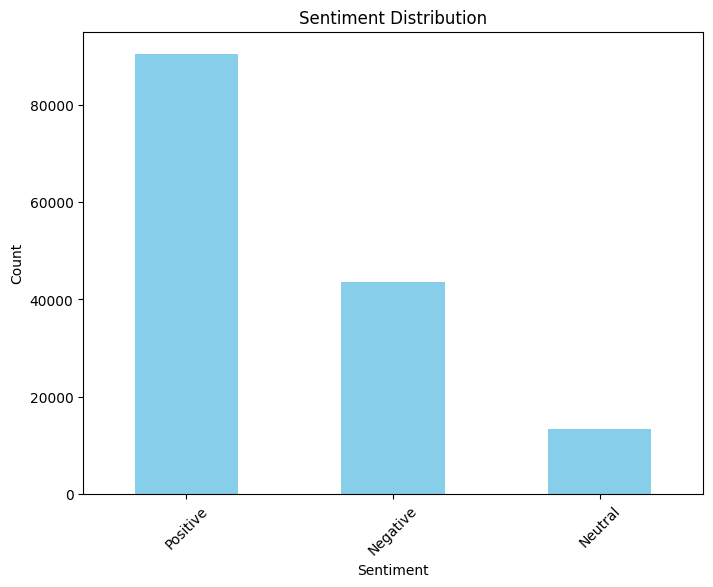

In [ ]:
sentiment_counts = new_data['Sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## **2. Data Splitting and Balancing**

### **2.1 Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

X = new_data['Summary']
y = new_data['Sentiment']
df_train, df_test = train_test_split(new_data,test_size=0.2, random_state=42, stratify=new_data['Sentiment'])

print("Training set shape:", df_train.shape, df_train.shape)
print("Testing set shape:", df_test.shape, df_test.shape)

Training set shape: (118017, 2) (118017, 2)
Testing set shape: (29505, 2) (29505, 2)


### **2.2 Balancing Classes**

In [ ]:
from sklearn.utils import resample

data_minority = df_train[df_train['Sentiment'] == 'Neutral']
data_majority_positive = df_train[df_train['Sentiment'] == 'Positive']
data_majority_negative = df_train[df_train['Sentiment'] == 'Negative']

minority_size = data_minority.shape[0]

data_majority_positive_downsampled = resample(data_majority_positive, replace=False, n_samples=minority_size, random_state=42)
data_majority_negative_downsampled = resample(data_majority_negative, replace=False, n_samples=minority_size, random_state=42)

train_downsampled = pd.concat([data_minority, data_majority_positive_downsampled, data_majority_negative_downsampled])

print("Train class distribution after downsampling:\n", train_downsampled['Sentiment'].value_counts())


Train class distribution after downsampling:
 Neutral     10625
Positive    10625
Negative    10625
Name: Sentiment, dtype: int64


## **3. Text Preprocessing :**

### **3.1 Text Cleaning**

In [ ]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    replace_white_space = ["\n"]
    for s in replace_white_space:
        text = text.replace(s, " ")

    replace_punctuation = ["’", "‘", "´", "`", "\'", r"\'"]
    for s in replace_punctuation:
        text = text.replace(s, "'")
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(lemmatized_tokens)

X_train = [clean_text(text) for text in train_downsampled['Summary'].values]
X_test = [clean_text(text) for text in df_test['Summary'].values]


### **3.2 Tokenization and Padding**

In [ ]:
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)


In [ ]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

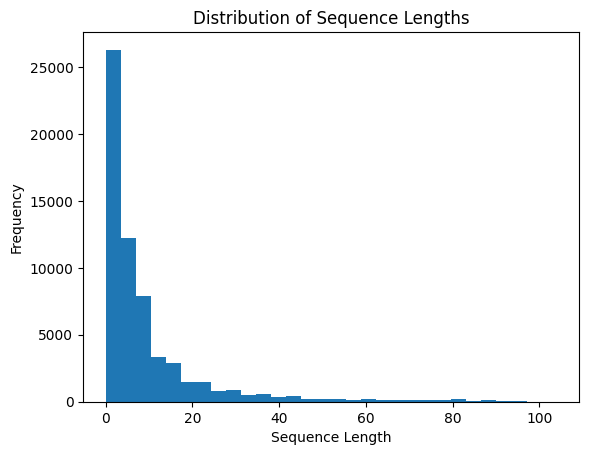

Selected maxlen: 37


In [ ]:
train_sequence_lengths = [len(seq) for seq in X_train_sequences]
test_sequence_lengths = [len(seq) for seq in X_test_sequences]

all_sequence_lengths = train_sequence_lengths + test_sequence_lengths

plt.hist(all_sequence_lengths, bins=30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

maxlen = int(np.percentile(all_sequence_lengths, 95))  # Cover 95% of sequences
print("Selected maxlen:", maxlen)


In [ ]:
maxlen = 37
X_train_padded = pad_sequences(X_train_sequences, padding='pre', maxlen=maxlen)
X_test_padded = pad_sequences(X_test_sequences, padding='pre', maxlen=maxlen)

print('Number of Tokens:', len(tokenizer.word_index))
print("Max Token Index:", X_train_padded.max(), "\n")

print('Sample Text Before Processing:', X_train[2390])
print('Sample Text After Processing:', X_train_padded[2390], '\n')


Number of Tokens: 14335
Max Token Index: 14335 

Sample Text Before Processing: not up to the mark
Sample Text After Processing: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   5 114  12   6
 196] 



In [ ]:
encoder = LabelEncoder()

y_train_encoded = encoder.fit_transform(train_downsampled['Sentiment'])
y_train = to_categorical(y_train_encoded)

y_test_encoded = encoder.transform(df_test['Sentiment'])
y_test = to_categorical(y_test_encoded)

In [ ]:
with open('labelencoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)


## **4. Model Building :**

### **4.1 Loading Pre-trained Word Embeddings**

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-03-07 00:51:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-03-07 00:51:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-03-07 00:51:03--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
from tensorflow.keras.layers import Embedding

def load_glove_embeddings(embedding_path, word_index, embedding_dim):
    embeddings_index = {}
    with open(embedding_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_dim = 100
embedding_path = '/content/glove.6B.100d.txt'

embedding_matrix = load_glove_embeddings(embedding_path, tokenizer.word_index, embedding_dim)

In [ ]:
embedding_matrix.shape

(14336, 100)

### **4.2 Defining LSTM Model Architecture**

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 37, 100)           1433600   
                                                                 
 spatial_dropout1d_2 (Spati  (None, 37, 100)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_4 (Bidirecti  (None, 37, 256)           234496    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 37, 128)           164352    
 onal)                                                           
                                                                 
 conv1d_2 (Conv1D)           (None, 35, 64)            24640     
                                                      

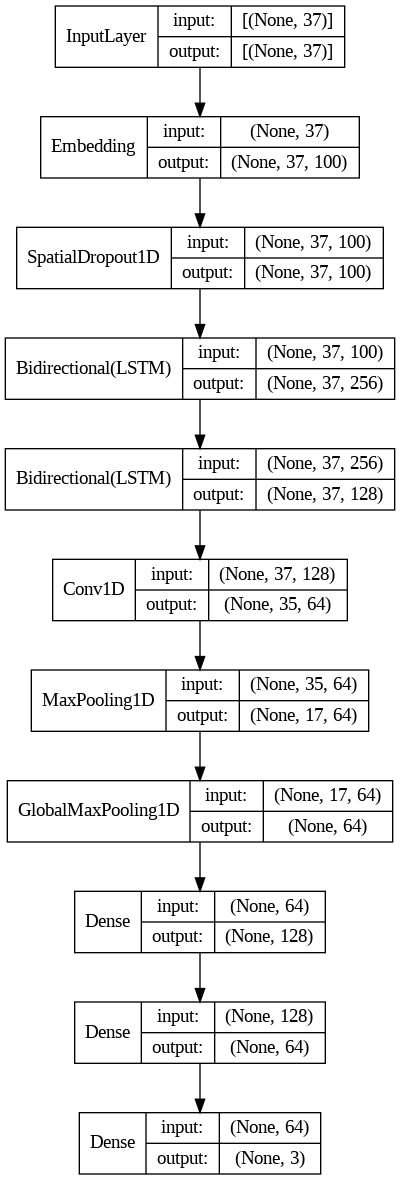

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, SpatialDropout1D, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.utils import plot_model

maxlen = 37

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False))
model.add(SpatialDropout1D(0.1))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

print(model.summary())

with open('model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

plot_model(model, to_file='model_flowchart.png', show_shapes=True, show_layer_names=False)


### **4.3 Compiling the Model**

In [ ]:
custom_lr = 0.0001
optimizer = Adam(learning_rate=custom_lr)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## **5. Model Training and Evaluation :**

### **5.1 Training the Model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define model checkpoint callback
checkpoint_filepath = 'best_model.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Train the model with callbacks
history = model.fit(
    X_train_padded, y_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_test_padded, y_test),
    callbacks=[model_checkpoint]
)


Epoch 1/30
247/250 [============================>.] - ETA: 0s - loss: 0.1540 - accuracy: 0.9440
Epoch 1: val_accuracy improved from -inf to 0.85823, saving model to best_model.h5
250/250 [==============================] - 17s 25ms/step - loss: 0.1540 - accuracy: 0.9440 - val_loss: 0.6246 - val_accuracy: 0.8582
Epoch 2/30
  5/250 [..............................] - ETA: 3s - loss: 0.1604 - accuracy: 0.9406

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


247/250 [============================>.] - ETA: 0s - loss: 0.1535 - accuracy: 0.9428
Epoch 2: val_accuracy did not improve from 0.85823
250/250 [==============================] - 5s 19ms/step - loss: 0.1531 - accuracy: 0.9430 - val_loss: 0.6245 - val_accuracy: 0.8577
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9430
Epoch 3: val_accuracy improved from 0.85823 to 0.85887, saving model to best_model.h5
250/250 [==============================] - 8s 31ms/step - loss: 0.1523 - accuracy: 0.9430 - val_loss: 0.6264 - val_accuracy: 0.8589
Epoch 4/30
248/250 [============================>.] - ETA: 0s - loss: 0.1529 - accuracy: 0.9436
Epoch 4: val_accuracy improved from 0.85887 to 0.85901, saving model to best_model.h5
250/250 [==============================] - 8s 31ms/step - loss: 0.1529 - accuracy: 0.9436 - val_loss: 0.6266 - val_accuracy: 0.8590
Epoch 5/30
247/250 [============================>.] - ETA: 0s - loss: 0.1482 - accuracy: 0.9454
Epoch 5:

### **5.2 Evaluating the Model**

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model(checkpoint_filepath)
loss, accuracy = best_model.evaluate(X_test_padded, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

923/923 [==============================] - 7s 6ms/step - loss: 0.6274 - accuracy: 0.8595
Test Loss: 0.6274470686912537
Test Accuracy: 0.8595153093338013


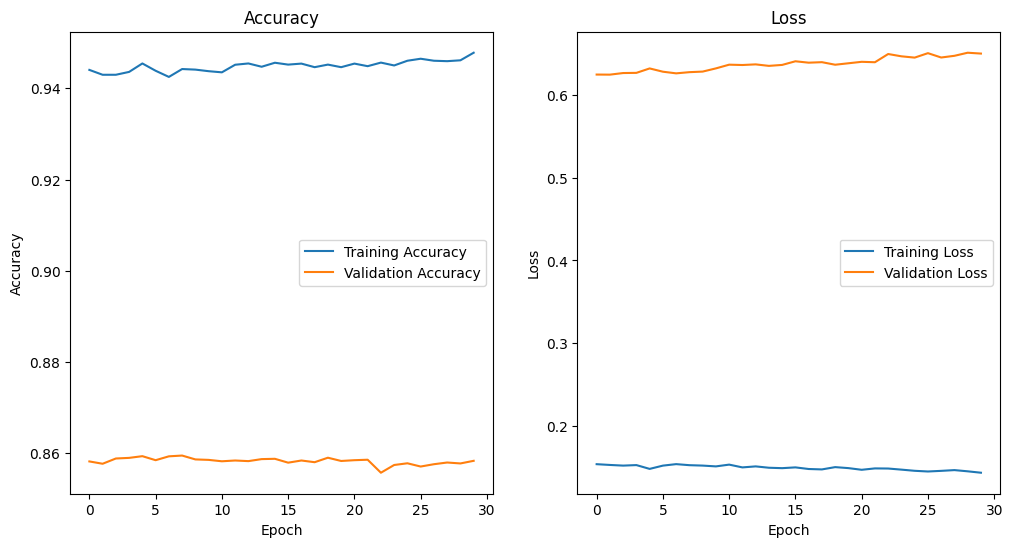

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.show()
plt.savefig('training_plot.png')
plt.show()

## **6. Model Evaluation Metrics :**

### **6.1 Classification Report**

In [ ]:
best_model = load_model(checkpoint_filepath)
y_pred_prob = best_model.predict(X_test_padded)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_categorical = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_categorical, y_pred)
recall = recall_score(y_test_categorical, y_pred, average='weighted')
precision = precision_score(y_test_categorical, y_pred, average='weighted')
f1 = f1_score(y_test_categorical, y_pred, average='weighted')

print("Overall Accuracy:", accuracy)
print("Overall Recall:", recall)
print("Overall Precision:", precision)
print("Overall F1 Score:", f1)

print("\nClassification Report:")
print(classification_report(y_test_categorical, y_pred))

923/923 [==============================] - 8s 7ms/step
Overall Accuracy: 0.8595153363836637
Overall Recall: 0.8595153363836637
Overall Precision: 0.9030656506617027
Overall F1 Score: 0.874424584721564

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      8727
           1       0.41      0.78      0.54      2656
           2       0.97      0.88      0.93     18122

    accuracy                           0.86     29505
   macro avg       0.76      0.83      0.78     29505
weighted avg       0.90      0.86      0.87     29505



In [ ]:
conf_matrix = confusion_matrix(y_test_categorical, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 7381  1194   152]
 [  360  2074   222]
 [  359  1600 16163]]
